<a href="https://colab.research.google.com/github/eunjin917/PnuFintechCompetition/blob/main/Colab/predict_model(%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ori_data = []
datasize = 2 # 풋고추[0], 새송이[1]
data = []

for i in range(datasize):
  ori_data.append(pd.read_csv("/content/drive/MyDrive/fintech_project/data/sample_{}_total.csv".format(i), sep=r'\s*,\s*')) # 2021-01-04부터 2023-01-23까지 2년치 데이터
  data.append(ori_data[i].sort_values(by=['DELNG_DE'])[['DELNG_DE', 'PRI_AVE']])

In [ ]:
good_type = []
company_list = []

for i in range(datasize):
  for j in range(len(ori_data[i])):
    good_type.append(ori_data[i]["PRDLST_NM"][j])
    company_list.append(ori_data[i]["CPR_NM"][j])

print(list(set(good_type)))
print(list(set(company_list)))

['풋고추', '새송이']
['농협가락(공)', '서울청과', '동화청과', '한국청과', '중앙청과']


법인별 평균가의 평균가를 구해 target값으로 설정한다.

In [ ]:
day_mean = [] # 날짜/ 평균값 pandas 
x_shift_data = [] # 평균가가 shift된 입력 데이터 (input) 
timestep = 10  # 최근 10영업일로 다음 값 예측
mean_values = [] 
date = []

for i in range(datasize):
  x_shift_data.append(data[i].groupby('DELNG_DE', as_index=False)['PRI_AVE'].mean()) # ['농협가락(공)', '서울청과', '동화청과', '한국청과', '중앙청과']의 평균값 
  x_shift_data[i]['PRI_AVE'] = round(x_shift_data[i]['PRI_AVE'],2)
  day_mean.append(x_shift_data[i][["DELNG_DE","PRI_AVE"]])
  for s in range(1, timestep+1):
    x_shift_data[i]['shift_{}'.format(s)] = x_shift_data[i]['PRI_AVE'].shift(s)

for i in range(datasize):
  x_shift_data[i] = x_shift_data[i].dropna().drop("PRI_AVE",axis=1).drop("DELNG_DE",axis=1) #자신의 평균가 삭제 => 자신의 평균가를 예측하기 위해 자신의 평균가를 입력으로 넣지 않음, 날짜도 삭제
  mean_values.append(day_mean[i]["PRI_AVE"].tolist())
  date.append(day_mean[i]["DELNG_DE"].tolist())

x_data = [] # 입력 데이터
y_data = [] # 타겟 데이터

for i in range(datasize):
  x_data.append(np.array(x_shift_data[i][x_shift_data[i].columns].values.tolist())) # 모든 칼럼 값들을 가진 행들을 리스트화 
  y_data.append(np.array(mean_values[i][timestep:]).reshape(-1,1)) #timestep만큼 삭제된 정보 이후의 데이터의 타겟값를 반영
  date[i] = date[i][timestep:]

In [ ]:
x_data

In [ ]:
y_data

MinMaxScaler를 통해 데이터 전처리를 하였다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler # 전처리 
from pickle import dump


x_model_sc = [] 
y_model_sc = [] 
x_data_sc = []
y_data_sc = []
for i in range(datasize):
  x_model_sc.append(MinMaxScaler())
  x_model_sc[i].fit(x_data[i])
  y_model_sc.append(MinMaxScaler())
  y_model_sc[i].fit(y_data[i])
  x_data_sc.append(x_model_sc[i].transform(x_data[i]))
  y_data_sc.append(y_model_sc[i].transform(y_data[i]))
  dump(x_model_sc[i],open('/content/drive/MyDrive/fintech_project/scaler/x_sc{}.pkl'.format(i),'wb'))
  dump(y_model_sc[i],open('/content/drive/MyDrive/fintech_project/scaler/y_sc{}.pkl'.format(i),'wb'))



In [ ]:
from sklearn.model_selection import train_test_split

x_train = [] 
x_test = []
y_train = [] 
y_test = [] 

for i in range(datasize):
  a,b,c,d = train_test_split(x_data_sc[i], y_data_sc[i], test_size=0.2)
  x_train.append(a)
  x_test.append(b)
  y_train.append(c)
  y_test.append(d)


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = [] 
history = [] 
for i in range(datasize):
  model.append(keras.Sequential())
  model[i].add(keras.layers.LSTM(512, dropout=0.1, return_sequences = True, input_shape = (x_train[i].shape[1], 1)))
  model[i].add(keras.layers.LSTM(256, dropout=0.1, return_sequences = True))
  model[i].add(keras.layers.LSTM(128, dropout=0.1, return_sequences = True))
  model[i].add(keras.layers.LSTM(64, dropout=0.1, return_sequences = True))
  model[i].add(keras.layers.LSTM(32, dropout=0.1))
  model[i].add(keras.layers.Dense(1))
  model[i].summary()

  model[i].compile(optimizer = "adam", loss = 'mean_squared_error')
  checkpoint_cb =keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/fintech_project/model/LSTM-model{}_adam.h5'.format(i))
  early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
  history.append(model[i].fit(x_train[i], y_train[i], epochs=1000, batch_size=64,
                    validation_data=(x_test[i], y_test[i]), callbacks=[checkpoint_cb,early_stopping_cb]))
print('finish')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 10, 256)           787456    
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           197120    
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2,099,105
Trainable params: 2,099,105
Non-

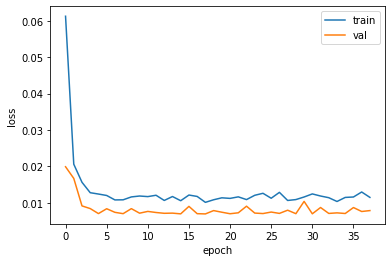

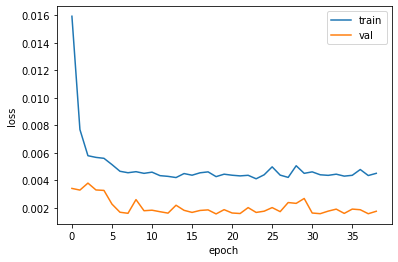

In [ ]:
for i in range(datasize):
  plt.plot(history[i].history['loss'])
  plt.plot(history[i].history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train','val'])
  plt.show()

In [ ]:
pred = [] 
for i in range(datasize):
  x_data_sc = x_sc[i].transform(x_data[i])
  pred.append(y_sc[i].inverse_transform(model[i].predict(x_data_sc)))

17/17 [==============================] - 3s 57ms/step


mse 값

In [ ]:
for i in range(datasize):
  print(mean_absolute_error(y_data[i],pred[i]))

607.399543234349
329.4792403541421


r2score 값

In [ ]:
for i in range(datasize):
  print(r2_score(y_data[i], pred[i]))  

0.7562948230336782
0.41392877733789346


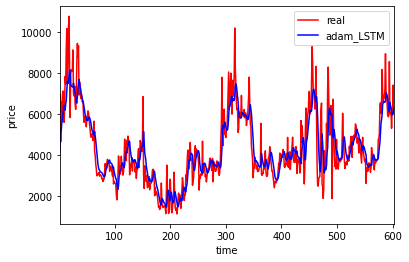

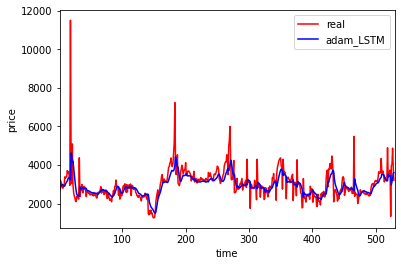

In [ ]:
for i in range(datasize):
  plt.figure()
  plt.plot(y_data[i], color='red', label='real')
  plt.plot(pred[i], color='blue', label='adam_LSTM')

  # plt.title('SEC stock price prediction')
  plt.xlabel('time')
  plt.ylabel('price')
  plt.xlim([1, len(y_data[i])]) 
  plt.legend()
  plt.show()
# print("내일 SEC 주가 :", df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')

In [ ]:
date_pred_dic_list = []
for i in range(datasize):
  date_pred_dic = {}
  for j in range(len(pred[i])):
    date_pred_dic[date[i][j]] = pred[i][j][0]
  date_pred_dic_list.append(date_pred_dic)

In [ ]:
update_ori_data = [] # 예측값이 업데이트된 csv

for i in range(datasize):
  update_ori_data.append(ori_data[i])
  update_ori_data[i] = update_ori_data[i].drop(update_ori_data[i][update_ori_data[i]['DELNG_DE'] < date[i][0]].index)
  delng_de_list = update_ori_data[i]['DELNG_DE'].tolist()
  delng_de_pred_list = [] 
  for j in range(len(update_ori_data[i])):
    delng_de_pred_list.append(date_pred_dic_list[i][delng_de_list[j]])
  update_ori_data[i]['PRI_PRED'] = delng_de_pred_list
  print(update_ori_data[i])


      Unnamed: 0  Unnamed: 0.1    DELNG_DE MRKT_NM CPR_NM PRDLST_NM SPCIES_NM  \
6              6             6  2021-01-15  서울가락도매   중앙청과       풋고추        청양   
7              7             7  2021-01-16  서울가락도매   중앙청과       풋고추        청양   
8              8             8  2021-01-18  서울가락도매   중앙청과       풋고추        청양   
9              9             9  2021-01-20  서울가락도매   중앙청과       풋고추        청양   
10            10            10  2021-01-21  서울가락도매   중앙청과       풋고추        청양   
...          ...           ...         ...     ...    ...       ...       ...   
2186           5             5  2023-01-14  서울가락도매   한국청과       풋고추        청양   
2187           6             6  2023-01-18  서울가락도매   한국청과       풋고추        청양   
2188           7             7  2023-01-19  서울가락도매   한국청과       풋고추        청양   
2189           8             8  2023-01-20  서울가락도매   한국청과       풋고추        청양   
2190           9             9  2023-01-21  서울가락도매   한국청과       풋고추        청양   

     GRAD weight  PRI_MAX  

In [ ]:
for i in range(datasize):
  update_ori_data[i] = update_ori_data[i].drop(['Unnamed: 0','Unnamed: 0.1'], axis=1) 
  update_ori_data[i].to_csv('/content/drive/MyDrive/fintech_project/update_data/update_data{}.csv'.format(i))
  update_ori_data[i].to_excel('/content/drive/MyDrive/fintech_project/update_data/update_data{}.xlsx'.format(i))